# Stress Prediction using ANN

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
path = '../../../data/03_primary/WESAD_preprocessed_int15_add15/combined_subjects.csv'
data = pd.read_csv(path, index_col=0)
data.head()

net_acc_mean  net_acc_std  net_acc_min  net_acc_max  EDA_phasic_mean  \
0      1.331891     0.153556     1.014138     1.678399         2.247876   
1      1.218994     0.090108     1.014138     1.485800         1.781323   
2      1.143312     0.110987     0.948835     1.485800         1.173169   
3      1.020669     0.135308     0.811090     1.239944         0.311656   
4      0.887458     0.116048     0.727406     1.125306         0.163826   

   EDA_phasic_std  EDA_phasic_min  EDA_phasic_max  EDA_smna_mean  \
0        1.112076        0.367977        4.459367       1.592308   
1        1.203991        0.232625        4.459367       1.347750   
2        1.285422        0.006950        4.459367       0.752335   
3        0.278650        0.006950        1.303071       0.198576   
4        0.110277        0.006950        0.369298       0.118080   

   EDA_smna_std  EDA_smna_min  EDA_smna_max  EDA_tonic_mean  EDA_tonic_std  \
0      2.645333  3.096902e-08     17.418821        0.608263       1.212010   
1      2.666659  3.096902e-08     17.418821        0.731985       1.171627   
2      1.958546  3.096902e-08     17.418821        1.110242       1.112268   
3      0.413802  3.309991e-08      2.788862        1.598995       0.350355   
4      0.237575  2.787285e-08      1.300810        1.342085       0.405980   

   EDA_tonic_min  EDA_tonic_max  BVP_mean     BVP_std  BVP_min  BVP_max  \
0      -1.213173       2.554750 -0.043934  112.391233  -392.28   554.77   
1      -1.213173       2.477276 -1.189267  120.431399  -392.28   554.77   
2      -1.213173       2.037179  0.280427   87.571000  -357.53   371.12   
3       0.959752       2.037179  0.055833   68.797466  -345.19   359.57   
4       0.945946       2.037179  0.096681   43.606312  -289.26   209.89   

   TEMP_mean  TEMP_std  TEMP_min  TEMP_max  ACC_x_mean  ACC_x_std  ACC_x_min  \
0  35.816000  0.017436     35.77     35.87    0.024658   0.018284  -0.037843   
1  35.796111  0.029522     35.75     35.87    0.020313   0.019242  -0.037843   
2  35.763056  0.044673     35.68     35.87    0.016618   0.015316  -0.021330   
3  35.725000  0.033491     35.66     35.81    0.022681   0.012560  -0.006881   
4  35.701333  0.022420     35.66     35.75    0.028105   0.010415   0.002752   

   ACC_x_max  ACC_y_mean  ACC_y_std  ACC_y_min  ACC_y_max  ACC_z_mean  \
0   0.087383    0.000017   0.000013  -0.000026   0.000060    0.000017   
1   0.087383    0.000014   0.000013  -0.000026   0.000060    0.000014   
2   0.071558    0.000011   0.000011  -0.000015   0.000049    0.000011   
3   0.054356    0.000016   0.000009  -0.000005   0.000037    0.000016   
4   0.054356    0.000019   0.000007   0.000002   0.000037    0.000019   

   ACC_z_std  ACC_z_min  ACC_z_max    0_mean     0_std     0_min     0_max  \
0   0.000013  -0.000026   0.000060  0.027558  0.013523  0.000000  0.087383   
1   0.000013  -0.000026   0.000060  0.023420  0.015310  0.000000  0.087383   
2   0.000011  -0.000015   0.000049  0.018759  0.012604  0.000000  0.071558   
3   0.000009  -0.000005   0.000037  0.022888  0.012180  0.000688  0.054356   
4   0.000007   0.000002   0.000037  0.028105  0.010415  0.002752  0.054356   

   BVP_peak_freq  TEMP_slope  subject  label  
0       0.080556   -0.000102        2      1  
1       0.144444   -0.000424        2      1  
2       0.102778   -0.000814        2      1  
3       0.108333   -0.000524        2      1  
4       0.147222   -0.000165        2      1

In [5]:
pd.set_option('display.max_rows', 10)

### Data Preparation

#### Merged amusement
First we will merge the amusement data with the baseline data as after the EDA we found out that they are very simmilar.

In [6]:
data_merged_am = data.copy()
data_merged_am["label"] = data_merged_am["label"].replace([0], 1)
data_merged_am["label"].unique()

array([1, 2], dtype=int64)

Now we will split the data into train, validation and test sets.

In [7]:
features = ['net_acc_std', 'net_acc_max', 'EDA_tonic_mean', 'EDA_tonic_min', 'EDA_tonic_max']
X = data_merged_am[features]
y = data_merged_am["label"]

X_train, X_test, y_train_merged_am, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training (1337 samples) and 20% test (334 samples)
X_val, X_test, y_val_merged_am, y_test_merged_am = train_test_split(X_test, y_test, test_size=0.1, random_state=42) # 90% of test set is used for validation (301 samples) and 10% for testing (33 samples)

We also need to scale the data so it lies between 0 and 1. This is important because the NN algorithm works better with scaled data, as generally activation function use values between 0 and 1.

In [8]:
scaler = MinMaxScaler()
X_train_merged_am = scaler.fit_transform(X_train)
X_val_merged_am = scaler.transform(X_val)
X_test_merged_am = scaler.transform(X_test)

#### Dropped amusement
First we will drop the amusement data to see if merging it with baseline confuses the algorithm.

In [9]:
data_no_am = data.copy()
data_no_am = data_no_am[data_no_am["label"] != 0]
data_merged_am["label"].unique()

array([1, 2], dtype=int64)

Now we will again split the data into train, validation and test sets and scale it.

In [10]:
X = data_no_am[features]
y = data_no_am["label"]

X_train, X_test, y_train_no_am, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test
X_val, X_test, y_val_no_am, y_test_no_am = train_test_split(X_test, y_test, test_size=0.1, random_state=42) # 90% of test set is used for validationand 10% for testing

scaler = MinMaxScaler()
X_train_no_am = scaler.fit_transform(X_train)
X_val_no_am = scaler.transform(X_val)
X_test_no_am = scaler.transform(X_test)

### Modeling and Training

We will create a function that will create, compile and train a model so we can easily try different models and compare them. We will use the Sequential model from Keras, which is a linear stack of layers. We will add the Dense layers, which are just regular densely connected NN layers. The last layer will have 3 neurons (the number of labels) by default. We will use the relu activation function for the hidden layers and the softmax activation function for the last one. The softmax function is used for multiclass classification problems, it returns the probability of each class.

In [11]:
def build_model(neurons_per_layer=[64, 64], n_outputs=3):
    model = Sequential()

    for i in range(len(neurons_per_layer)):
            model.add(Dense(neurons_per_layer[i], activation='relu'))

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Merged amusement
In order to decide for how many epochs we will train the model, we will devide the lenght of the dataset by the batch size and multiply it by two. This will give us a good estimate of how many epochs we need to train the model.

In [12]:
batch_size = 32
len(y_train_merged_am) / batch_size * 2

104.5

The first model we will create will behave two layers with 64 neurons each. We will train for 20 epochs and use a standard batch size of 32.

In [13]:
model1 = build_model()
history1 = model1.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 5ms/step - loss: 0.8166 - accuracy: 0.6848 - val_loss: 0.5538 - val_accuracy: 0.8064
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 0.4615 - accuracy: 0.8194 - val_loss: 0.3350 - val_accuracy: 0.8859
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3524 - accuracy: 0.8648 - val_loss: 0.2800 - val_accuracy: 0.9019
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3212 - accuracy: 0.8786 - val_loss: 0.2619 - val_accuracy: 0.9045
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8786 - val_loss: 0.2666 - val_accuracy: 0.9098
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8798 - val_loss: 0.2532 - val_accuracy: 0.9151
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.8822 - val_loss: 0.2532 - val_accuracy: 0.9125
Epoch 8/100
5

We will also try models with 2 layers of 128 nodes and 3 layers with 1 layer of 64 and 2 layers of 128 nodes. We will again train for 20 epochs and use a standard batch size of 32.

In [14]:
model2 = build_model([128, 128])
history2 = model2.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 5ms/step - loss: 0.7081 - accuracy: 0.6836 - val_loss: 0.4573 - val_accuracy: 0.7639
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4044 - accuracy: 0.8403 - val_loss: 0.3038 - val_accuracy: 0.8806
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3348 - accuracy: 0.8672 - val_loss: 0.2650 - val_accuracy: 0.8992
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3144 - accuracy: 0.8792 - val_loss: 0.2564 - val_accuracy: 0.9072
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3089 - accuracy: 0.8840 - val_loss: 0.2541 - val_accuracy: 0.9125
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3069 - accuracy: 0.8810 - val_loss: 0.2519 - val_accuracy: 0.9151
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8792 - val_loss: 0.2531 - val_accuracy: 0.9125
Epoch 8/100
5

In [15]:
model3 = build_model([512, 256, 256])
history3 = model3.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 11ms/step - loss: 0.4843 - accuracy: 0.8038 - val_loss: 0.2509 - val_accuracy: 0.9072
Epoch 2/100
53/53 [==============================] - 0s 6ms/step - loss: 0.3355 - accuracy: 0.8696 - val_loss: 0.2464 - val_accuracy: 0.9125
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 0.3054 - accuracy: 0.8810 - val_loss: 0.2402 - val_accuracy: 0.9072
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2933 - accuracy: 0.8816 - val_loss: 0.2428 - val_accuracy: 0.9151
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2906 - accuracy: 0.8768 - val_loss: 0.2362 - val_accuracy: 0.9151
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2897 - accuracy: 0.8822 - val_loss: 0.2486 - val_accuracy: 0.9178
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2953 - accuracy: 0.8780 - val_loss: 0.2253 - val_accuracy: 0.9151
Epoch 8/100


#### Dropped amusement

We will train the same models as the ones we trained with the merged data.

In [16]:
batch_size = 32
len(y_train_no_am) / batch_size * 2

88.0

In [17]:
model1_no_am = build_model()
history1_no_am = model1_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 6ms/step - loss: 0.8012 - accuracy: 0.6399 - val_loss: 0.5987 - val_accuracy: 0.7057
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.7820 - val_loss: 0.3977 - val_accuracy: 0.8766
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3862 - accuracy: 0.8516 - val_loss: 0.3171 - val_accuracy: 0.8892
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8594 - val_loss: 0.3127 - val_accuracy: 0.8829
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3376 - accuracy: 0.8636 - val_loss: 0.2906 - val_accuracy: 0.8987
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8622 - val_loss: 0.2906 - val_accuracy: 0.8987
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3309 - accuracy: 0.8651 - val_loss: 0.2832 - val_accuracy: 0.9019
Epoch 8/100
4

In [18]:
model2_no_am = build_model([128, 128])
history2_no_am = model2_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 5ms/step - loss: 0.7064 - accuracy: 0.6790 - val_loss: 0.4740 - val_accuracy: 0.8323
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4194 - accuracy: 0.8331 - val_loss: 0.3613 - val_accuracy: 0.8829
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.8516 - val_loss: 0.3021 - val_accuracy: 0.8861
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8572 - val_loss: 0.2903 - val_accuracy: 0.8956
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8622 - val_loss: 0.2884 - val_accuracy: 0.9051
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3305 - accuracy: 0.8672 - val_loss: 0.2840 - val_accuracy: 0.9051
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3284 - accuracy: 0.8643 - val_loss: 0.2830 - val_accuracy: 0.9019
Epoch 8/100
4

In [50]:
model3_no_am = build_model([512, 256, 256])
history3_no_am = model3_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 10ms/step - loss: 0.5204 - accuracy: 0.7869 - val_loss: 0.2927 - val_accuracy: 0.8892
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.3464 - accuracy: 0.8587 - val_loss: 0.2876 - val_accuracy: 0.8829
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.3376 - accuracy: 0.8594 - val_loss: 0.2698 - val_accuracy: 0.8987
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3207 - accuracy: 0.8636 - val_loss: 0.2692 - val_accuracy: 0.8956
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3155 - accuracy: 0.8651 - val_loss: 0.2624 - val_accuracy: 0.9051
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3260 - accuracy: 0.8679 - val_loss: 0.2789 - val_accuracy: 0.8892
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3255 - accuracy: 0.8544 - val_loss: 0.2543 - val_accuracy: 0.9051
Epoch 8/100


### Evaluation 
In order to compare the three models we will plot the loss and accuracy of all of them.

In [20]:
def plot_evaluation(eval_type='accuracy', histories=[], labels=[]):
    fig, axs = plt.subplots(ncols=2, figsize=(16,5))
    for i in range(len(histories)):
        axs[0].plot(histories[i].history[eval_type])
        axs[1].plot(histories[i].history['val_' + eval_type])

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel=eval_type)
        ax.legend(labels, loc='upper left')

    fig.suptitle(f'Model train and validation {eval_type}')

#### Merged amusement

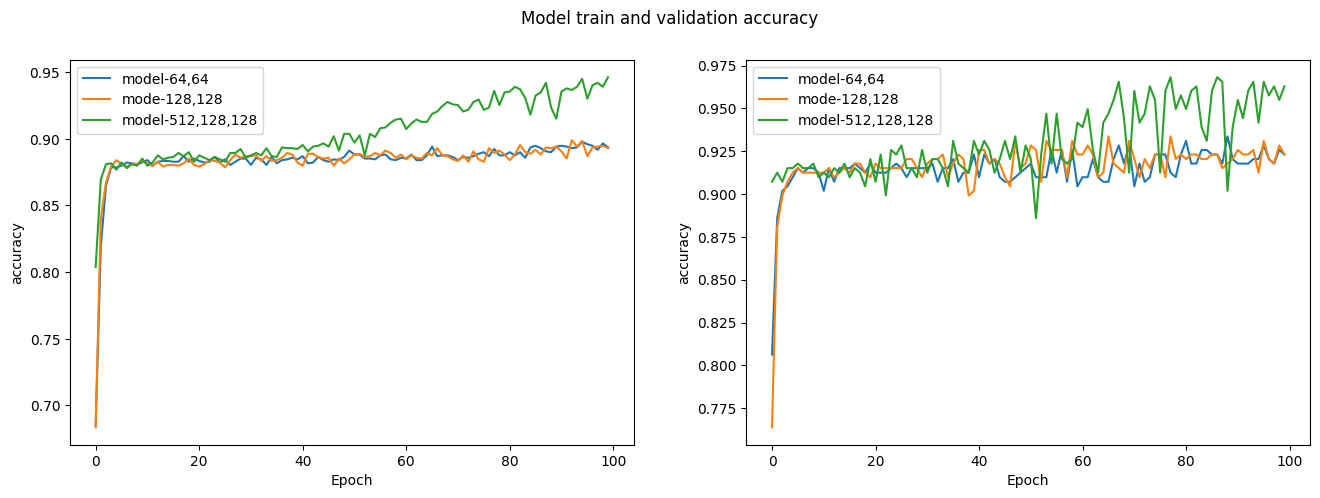

In [21]:
results = [history1, history2, history3]
labels = ['model-64,64', 'mode-128,128', 'model-512,128,128']
plot_evaluation('accuracy', results, labels)

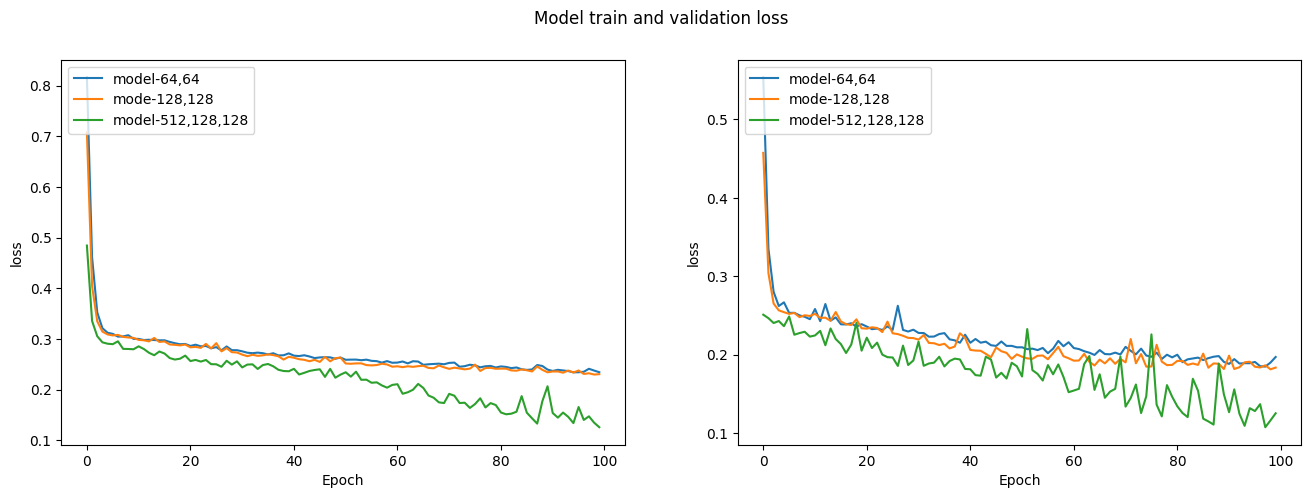

In [22]:
plot_evaluation('loss', results, labels)

We can conclude that the model with 3 layers of 512, 128 and 128 nodes in each layer is the best model. It has a loss of ~0.15 and accuracy of ~96%. We can also see that the model is not overfitting as the loss and accuracy of the validation set are very close to the ones of the training set. Now we will plot a confusion matrix to see how the model performs on each class.

12/12 [==============================] - 0s 3ms/step


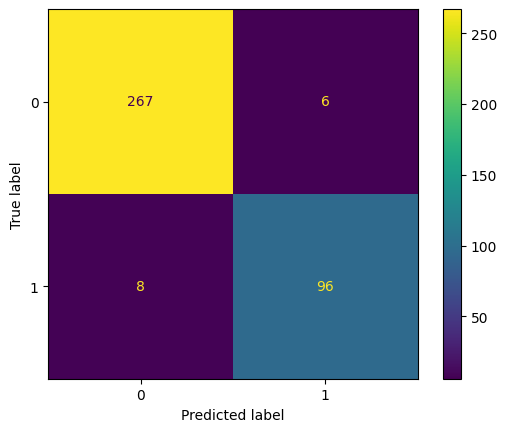

In [45]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

y_pred_merged_am = model3.predict(X_val_merged_am)
cm = confusion_matrix(y_val_merged_am, y_pred_merged_am.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [46]:
print(f"accuracy_score: {round(accuracy_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"balanced_accuracy: {round(balanced_accuracy_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"f1_score: {round(f1_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"recall_score: {round(recall_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"precision_score: {round(precision_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")

accuracy_score: 0.963
balanced_accuracy: 0.951
f1_score: 0.974
recall_score: 0.978
precision_score: 0.971


We can see that less than 5% of the data is misclassified. Additionally, the model has way higher precission than recall, most likely because of the fact that we have more data for the baseline class than the stress class.

#### Dropped amusement

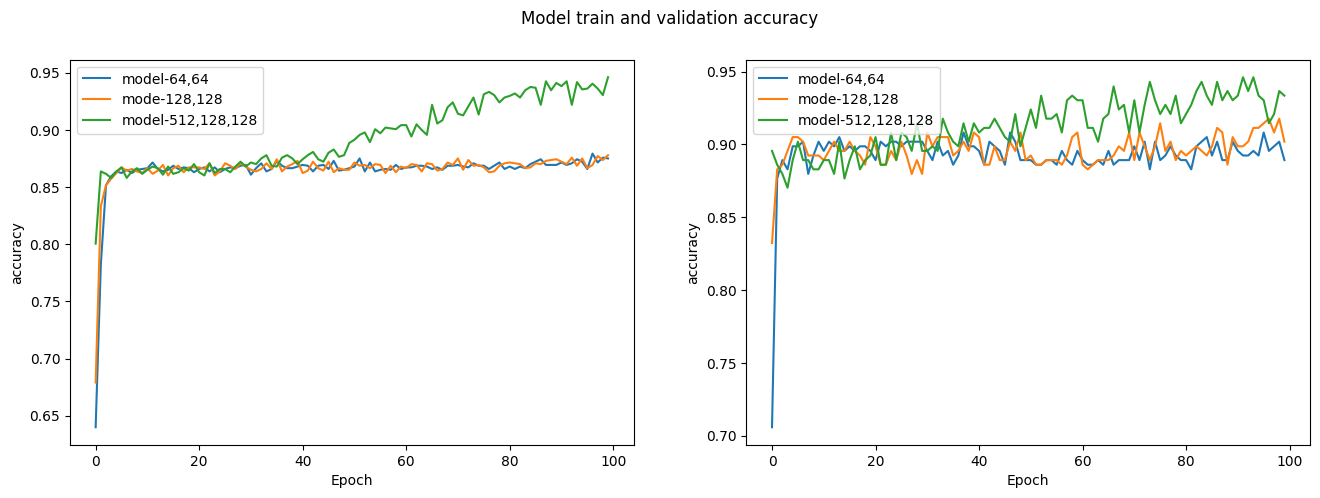

In [25]:
results_ = [history1_no_am, history2_no_am, history3_no_am]
labels_ = ['model-64,64', 'mode-128,128', 'model-512,128,128']
plot_evaluation('accuracy', results_, labels_)

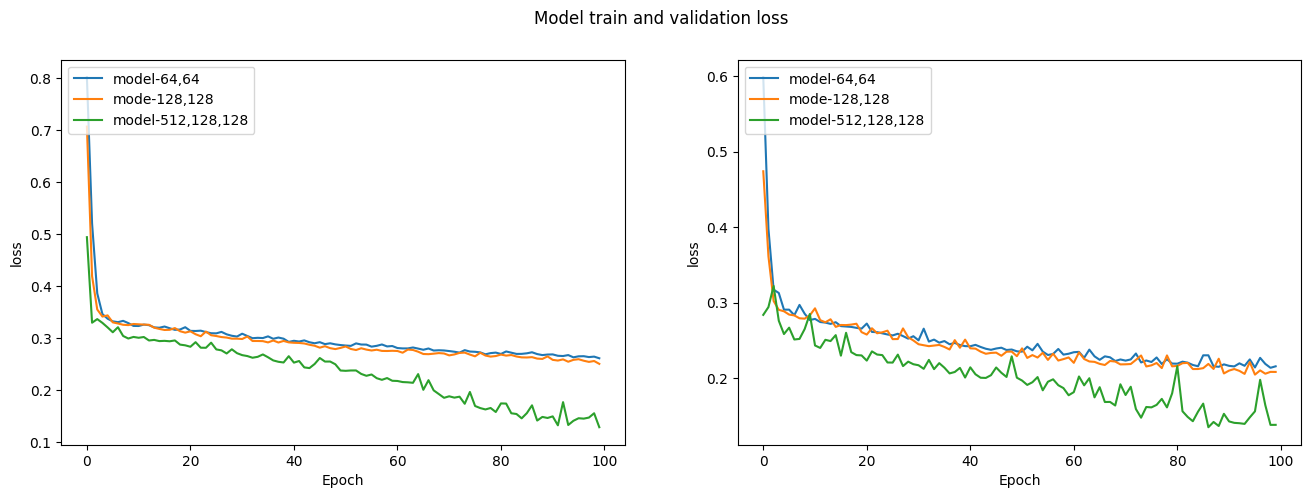

In [26]:
plot_evaluation('loss', results_, labels_)

We can conclude that the model with 3 layers of 512, 128 and 128 nodes in each layer is the best model. It has a loss of ~0.15 and accuracy of ~94%. We can also see that the model is not overfitting as the loss and accuracy of the validation set are very close to the ones of the training set. Now we will again plot a confusion matrix to see how the model performs on each class.

10/10 [==============================] - 0s 3ms/step


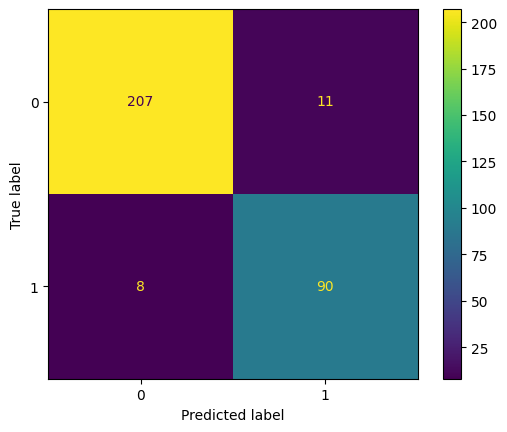

In [51]:
y_pred_no_am = model3_no_am.predict(X_val_no_am)
cm = confusion_matrix(y_val_no_am, y_pred_no_am.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [52]:
print(f"accuracy_score: {round(accuracy_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")
print(f"balanced_accuracy: {round(balanced_accuracy_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")
print(f"f1_score: {round(f1_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")
print(f"recall_score: {round(recall_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")
print(f"precision_score: {round(precision_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")

accuracy_score: 0.94
balanced_accuracy: 0.934
f1_score: 0.956
recall_score: 0.95
precision_score: 0.963


We can see that less than 5% of the data is misclassified. Additionally, in contrast with the `merged amusement` model, the `no amusement` madel has higher recall than precission. The reason for the slightly worse performance is most likely the smaller  amount of data.

#### Explainability

In order to get a better understanding of how the model works we will use the SHAP library. SHAP is a game theoretic approach to explain the output of any machine learning model. SHAP values represent a feature's responsibility for a change in the model output. The sum of the SHAP values equals the difference between the expected model output and the model output when all features are set to their average value.

In [29]:
import shap

def prediction_wrapper(X):
    return model3.predict([X[:,i] for i in range(X.shape[1])]).flatten()

#### Merged amusement
First we will plot the SHAP values for the test set.

In [30]:
explainer = shap.KernelExplainer(
    model3.predict,
    X_test_merged_am
)

shap_values = explainer.shap_values(X_test_merged_am)

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/42 [00:00<?, ?it/s]

40/40 [==============================] - 0s 1ms/step


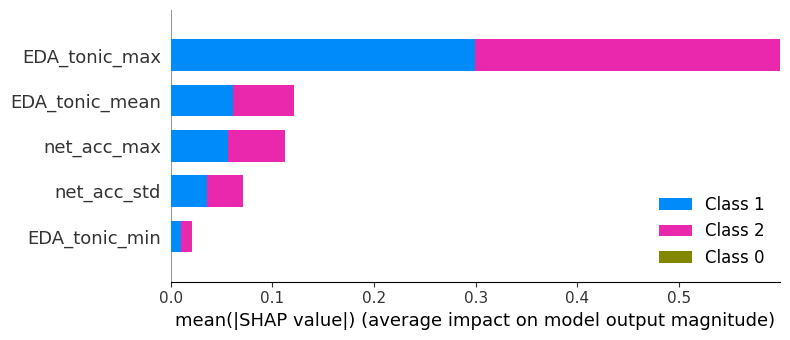

In [31]:
shap.summary_plot(shap_values=shap_values, features=X_test_merged_am, feature_names=features)

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val_merged_am[1])

Now we will use the Interpret ML library to visualize the local SHAP values for the first 10 samples of the test set.

In [33]:
from interpret import show
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.blackbox import ShapKernel
from interpret.blackbox import LimeTabular
from interpret.blackbox import MorrisSensitivity
from interpret.blackbox import PartialDependence

In [34]:
shap = ShapKernel(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
shap_local = shap.explain_local(X_test_merged_am[:10], y_test_merged_am[:10])

show(shap_local)

53/53 [==============================] - 0s 2ms/step


Using 1672 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Morris Sensitivity Analysis is a method for computing the sensitivity of a model's outputs to the inputs. It is a global sensitivity analysis method, which means that it can be used to analyze the sensitivity of the model's outputs to the inputs without having to train the model multiple times. The method is based on the idea that the model's outputs can be approximated by a linear function of the inputs. The method is based on the idea that the model's outputs can be approximated by a linear function of the inputs.

In [35]:
msa = MorrisSensitivity(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
msa_global = msa.explain_global()
show(msa_global)

188/188 [==============================] - 0s 2ms/step


We will also use the LIME method to explain the model. LIME is a model-agnostic method for explaining the predictions of any machine learning classifier. It is based on the idea that if we could approximate the classifier locally with a linear model, we could easily interpret the weights of the local linear model.

In [36]:
lime = LimeTabular(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
lime_local = lime.explain_local(X_test_merged_am[:5], y_test_merged_am[:5])

show(lime_local)

157/157 [==============================] - 0s 2ms/step


Partial Dependence Plots

Partial dependence plots show the marginal effect one or two features have on the predicted outcome of a machine learning model (e.g., the probability of a data point belonging to a particular class). PDPs are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way. The model is then used to predict outcomes on artificial data that has been manipulated to have certain values for the target feature of interest.

In [37]:
pdp = PartialDependence(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
pdp_global = pdp.explain_global()

show(pdp_global)
# takes ~20 minutes to run

53/53 [==============================] - 0s 2ms/step


#### Dropped amusement
We will use the same XAI methods as we used for the merged data.

In [38]:
import shap
explainer_no_am = shap.KernelExplainer(
    model3_no_am.predict,
    X_test_no_am
)

shap_values_no_am = explainer_no_am.shap_values(X_test_no_am)

2/2 [==============================] - 0s 2ms/step


  0%|          | 0/36 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


SHAP values

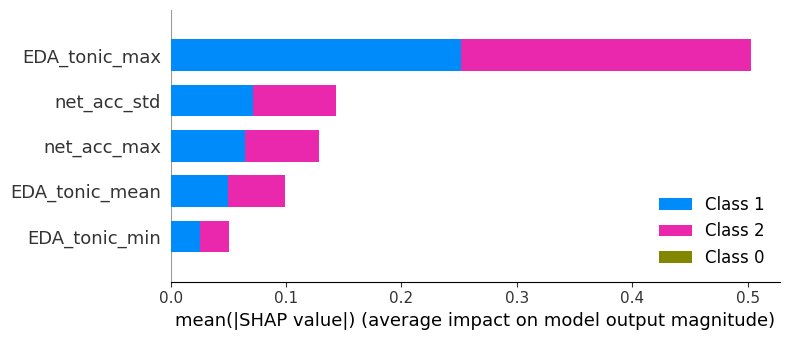

In [39]:
shap.summary_plot(shap_values=shap_values_no_am, features=X_test_no_am, feature_names=features)

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_no_am[1], X_val_no_am[1])

In [41]:
shap_no_am = ShapKernel(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
shap_local_no_am = shap_no_am.explain_local(X_test_no_am[:10], y_test_no_am[:10])

show(shap_local_no_am)

44/44 [==============================] - 0s 1ms/step


Using 1408 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Morris Sensitivity Analysis

In [42]:
msa_no_am = MorrisSensitivity(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
msa_global_no_am = msa_no_am.explain_global()
show(msa_global_no_am)

188/188 [==============================] - 0s 2ms/step


LIME

In [43]:
lime_no_am = LimeTabular(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
lime_local_no_am = lime_no_am.explain_local(X_test_no_am[:5], y_test_no_am[:5])

show(lime_local_no_am)

157/157 [==============================] - 0s 1ms/step


Partial Dependence Plots

In [44]:
pdp_no_am = PartialDependence(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
pdp_global_no_am = pdp_no_am.explain_global()

show(pdp_global_no_am)
# takes ~15 minutes to run

44/44 [==============================] - 0s 3ms/step
